## P1

In [ ]:
import torch
import numpy as np

def polynomial_fun(weights, x):
    """Calculate polynomial function value for given weights and input x."""
    # weights shape: [degree+1]
    # x shape: [num_samples]
    powers = torch.arange(start=0, end=weights.shape[0], dtype=torch.float32)
    x_powers = x.unsqueeze(-1) ** powers
    # Perform matrix multiplication instead of element-wise multiplication
    # Adjust weights view for correct matrix multiplication: [degree+1, 1]
    if weights.ndim == 1:
        weights = weights.view(-1, 1)
    # Matrix multiplication, x_powers shape: [num_samples, degree+1], weights shape: [degree+1, 1]
    return torch.matmul(x_powers, weights).squeeze()

def fit_polynomial_ls(X, Y, degree):
    """Fit a polynomial using least squares."""
    powers = torch.arange(start=0, end=degree+1, dtype=torch.float32)
    X_powers = X.unsqueeze(-1) ** powers
    # Solve using least squares: weights = (X^T X)^{-1} X^T Y
    XT_X = torch.matmul(X_powers.transpose(0,1), X_powers)
    XT_Y = torch.matmul(X_powers.transpose(0,1), Y.unsqueeze(-1))
    weights = torch.linalg.solve(XT_X, XT_Y)
    return weights.squeeze()

def fit_polynomial_sgd(X, Y, degree, learning_rate, epochs, minibatch_size):
    """Fit a polynomial using stochastic minibatch gradient descent."""
    #weights = torch.nn.Parameter(torch.randn(0, 1, dtype=torch.float32) * 0.1)
    weights = torch.nn.Parameter(torch.randn(0, 1, dtype=torch.float32)*10)
    optimizer = torch.optim.SGD([weights], lr=learning_rate, momentum=0.9)

    for epoch in range(epochs):
        permutation = torch.randperm(X.size()[0])
        for i in range(0, X.size()[0], minibatch_size):
            indices = permutation[i:i+minibatch_size]
            batch_x, batch_y = X[indices], Y[indices]

            optimizer.zero_grad()
            outputs = polynomial_fun(weights, batch_x)
            loss = torch.mean((outputs - batch_y) ** 2)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

    return weights

In [ ]:
import time

# Provided functions: polynomial_fun, fit_polynomial_ls, fit_polynomial_sgd

def generate_data(weights, num_samples, noise_std=0.5, x_range=(-20, 20)):
    x = torch.linspace(x_range[0], x_range[1], steps=num_samples)
    y_true = polynomial_fun(weights, x)
    noise = torch.randn(num_samples) * noise_std
    y_observed = y_true + noise
    return x, y_true, y_observed

def calculate_metrics(y_true, y_pred):
    difference = y_pred - y_true
    mean_diff = torch.mean(difference)
    std_diff = torch.std(difference)
    return mean_diff.item(), std_diff.item()

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2)).item()

In [ ]:
 # Generate training and test data
weights_true = torch.tensor([1.0, 2.0, 3.0])
x_train, y_train_true, y_train_observed = generate_data(weights_true, 20)
x_test, y_test_true, y_test_observed = generate_data(weights_true, 10)

for method in ['ls', 'sgd']:
    print(f"\nUsing {method.upper()} method:")
    for degree in [2, 3, 4]:

        if method == 'ls':
            start_time = time.time()
            weights = fit_polynomial_ls(x_train, y_train_observed, degree)
            duration = time.time() - start_time
        else:
            start_time = time.time()
            weights = fit_polynomial_sgd(x_train, y_train_observed, degree, learning_rate=0.1, epochs=3, minibatch_size=8).detach()
            duration = time.time() - start_time

        y_train_pred = polynomial_fun(weights, x_train)
        y_test_pred = polynomial_fun(weights, x_test)

        # Calculate metrics
        train_mean_diff, train_std_diff = calculate_metrics(y_train_true, y_train_pred)
        test_rmse = rmse(y_test_true, y_test_pred)
        #print(weights)
        #w_rmse = rmse(weights_true, weights)

        print(f"M={degree}: Train Mean Diff: {train_mean_diff:.3f}, Train Std Diff: {train_std_diff:.3f}, Test RMSE: {test_rmse:.3f}, Weight RMSE: {w_rmse:.3f}, Time: {duration:.3f}s")



Using LS method:
M=2: Train Mean Diff: -0.162, Train Std Diff: 0.138, Test RMSE: 0.231, Weight RMSE: 0.022, Time: 0.000s
M=3: Train Mean Diff: -0.163, Train Std Diff: 0.148, Test RMSE: 0.239, Weight RMSE: 0.022, Time: 0.000s
M=4: Train Mean Diff: -0.162, Train Std Diff: 0.151, Test RMSE: 0.250, Weight RMSE: 0.022, Time: 0.000s

Using SGD method:
Epoch 0, Loss: 913843.5
Epoch 1, Loss: 729236.875
Epoch 2, Loss: 173876.375
M=2: Train Mean Diff: -443.105, Train Std Diff: 404.942, Test RMSE: 652.732, Weight RMSE: 0.022, Time: 0.040s
Epoch 0, Loss: 857108.75
Epoch 1, Loss: 164700.6875
Epoch 2, Loss: 150500.21875
M=3: Train Mean Diff: -443.105, Train Std Diff: 404.942, Test RMSE: 652.732, Weight RMSE: 0.022, Time: 0.025s
Epoch 0, Loss: 64701.7734375
Epoch 1, Loss: 389262.78125
Epoch 2, Loss: 130746.7734375
M=4: Train Mean Diff: -443.105, Train Std Diff: 404.942, Test RMSE: 652.732, Weight RMSE: 0.022, Time: 0.009s


In [ ]:
# Generate training and test data
weights_true = torch.tensor([1.0, 2.0, 3.0])
x_train, y_train_true, y_train_observed = generate_data(weights_true, 20)
x_test, y_test_true, y_test_observed = generate_data(weights_true, 10)

for method in ['ls', 'sgd']:
    print(f"\nUsing {method.upper()} method:")
    for degree in [2, 3, 4]:
        if method == 'ls':
            start_time = time.time()
            weights = fit_polynomial_ls(x_train, y_train_observed, degree)
            duration = time.time() - start_time
        else:
            start_time = time.time()
            weights = fit_polynomial_sgd(x_train, y_train_observed, degree, learning_rate=0.01, epochs=3, minibatch_size=8).detach()
            duration = time.time() - start_time

        y_train_pred = polynomial_fun(weights, x_train)
        y_test_pred = polynomial_fun(weights, x_test)

        # Calculate metrics
        train_mean_diff, train_std_diff = calculate_metrics(y_train_true, y_train_pred)
        test_rmse = rmse(y_test_true, y_test_pred)

        print(f"M={degree}: Train Mean Diff: {train_mean_diff:.3f}, Train Std Diff: {train_std_diff:.3f}, Test RMSE: {test_rmse:.3f}, Time: {duration:.3f}s")



Using LS method:
M=2: Train Mean Diff: 0.092, Train Std Diff: 0.026, Test RMSE: 0.099, Time: 0.000s
M=3: Train Mean Diff: 0.092, Train Std Diff: 0.143, Test RMSE: 0.182, Time: 0.000s
M=4: Train Mean Diff: 0.092, Train Std Diff: 0.147, Test RMSE: 0.190, Time: 0.000s

Using SGD method:
Epoch 0, Loss: 218054.171875
Epoch 1, Loss: 728204.625
Epoch 2, Loss: 138347.71875
M=2: Train Mean Diff: -443.105, Train Std Diff: 404.942, Test RMSE: 652.732, Time: 0.014s
Epoch 0, Loss: 473246.84375
Epoch 1, Loss: 534536.25
Epoch 2, Loss: 44931.88671875
M=3: Train Mean Diff: -443.105, Train Std Diff: 404.942, Test RMSE: 652.732, Time: 0.007s
Epoch 0, Loss: 385962.84375
Epoch 1, Loss: 592309.4375
Epoch 2, Loss: 173876.8125
M=4: Train Mean Diff: -443.105, Train Std Diff: 404.942, Test RMSE: 652.732, Time: 0.007s


In [ ]:
weights_true = torch.tensor([1.0, 2.0, 3.0])
x_train, y_train_true, y_train_observed = generate_data(weights_true, 20)
x_test, y_test_true, y_test_observed = generate_data(weights_true, 10)

In [ ]:
import torch
import numpy as np
import time

def soft_polynomial_fun(x, coeffs, degree_importance):
    """Calculate polynomial function value for given coefficients, input x, and degree importance weights."""
    powers = torch.arange(degree_importance.numel(), dtype=torch.float32)
    x_powers = x.unsqueeze(-1) ** powers
    degree_weights = torch.sigmoid(degree_importance)  # Ensure weights are in [0, 1]
    weighted_coeffs = coeffs * degree_weights  # Apply importance weights to coefficients
    return torch.matmul(x_powers, weighted_coeffs.unsqueeze(-1)).squeeze()

def fit_flexible_polynomial_sgd(X, Y, max_degree, learning_rate, epochs, minibatch_size):
    """Fit a polynomial using stochastic minibatch gradient descent with flexible degree."""
    coeffs = torch.nn.Parameter(torch.randn(max_degree + 1, dtype=torch.float32) * 0.1)
    degree_importance = torch.nn.Parameter(torch.randn(max_degree + 1, dtype=torch.float32) * 0.1)
    optimizer = torch.optim.SGD([coeffs, degree_importance], lr=learning_rate, momentum=0.9)

    for epoch in range(epochs):
        permutation = torch.randperm(X.size()[0])
        for i in range(0, X.size()[0], minibatch_size):
            indices = permutation[i:i+minibatch_size]
            batch_x, batch_y = X[indices], Y[indices]

            optimizer.zero_grad()
            outputs = soft_polynomial_fun(batch_x, coeffs, degree_importance)
            loss = torch.mean((outputs - batch_y) ** 2)
            loss.backward()
            optimizer.step()

    return coeffs, degree_importance

# Generate synthetic data
x_train, y_train_true, y_train_observed = generate_data(weights_true, 20)
x_test, y_test_true, y_test_observed = generate_data(weights_true, 10)

# Fit the flexible polynomial model
max_degree = 4  # Set a maximum degree for the experiment
coeffs, degree_importance = fit_flexible_polynomial_sgd(x_train, y_train_observed, max_degree, learning_rate=0.01, epochs=5, minibatch_size=8)

# Predict and evaluate
y_pred = soft_polynomial_fun(x_test, coeffs, degree_importance)
mean_diff, std_diff = calculate_metrics(y_test_true, y_pred)
print(f"Optimised M approximation: {torch.sigmoid(degree_importance).detach()}")
print(f"Mean Difference: {mean_diff:.3f}, Std Deviation: {std_diff:.3f}")


Optimised M approximation: tensor([1., 0., 0., 0., 0.])
Mean Difference: 54.624, Std Deviation: 454.689


In [ ]:
import torch
import numpy as np
import time

def soft_polynomial_fun(x, coeffs, degree_importance):
    """Calculate polynomial function value for given coefficients, input x, and degree importance weights."""
    powers = torch.arange(degree_importance.numel(), dtype=torch.float32)
    x_powers = x.unsqueeze(-1) ** powers
    degree_weights = torch.sigmoid(degree_importance)  # Ensure weights are in [0, 1]
    weighted_coeffs = coeffs * degree_weights  # Apply importance weights to coefficients
    return torch.matmul(x_powers, weighted_coeffs.unsqueeze(-1)).squeeze()

def fit_flexible_polynomial_sgd(X, Y, max_degree, learning_rate, epochs, minibatch_size):
    """Fit a polynomial using stochastic minibatch gradient descent with flexible degree."""
    coeffs = torch.nn.Parameter(torch.randn(max_degree + 1, dtype=torch.float32) * 0.1)
    degree_importance = torch.nn.Parameter(torch.randn(max_degree + 1, dtype=torch.float32) * 0.1)
    optimizer = torch.optim.Adam([coeffs, degree_importance], lr=learning_rate)

    for epoch in range(epochs):
        permutation = torch.randperm(X.size()[0])
        for i in range(0, X.size()[0], minibatch_size):
            indices = permutation[i:i+minibatch_size]
            batch_x, batch_y = X[indices], Y[indices]

            optimizer.zero_grad()
            outputs = soft_polynomial_fun(batch_x, coeffs, degree_importance)
            loss = torch.mean((outputs - batch_y) ** 2)
            loss.backward()
            optimizer.step()

    return coeffs, degree_importance

# Generate synthetic data
x_train, y_train_true, y_train_observed = generate_data(weights_true, 20)
x_test, y_test_true, y_test_observed = generate_data(weights_true, 10)

# Fit the flexible polynomial model
max_degree = 4  # Set a maximum degree for the experiment
coeffs, degree_importance = fit_flexible_polynomial_sgd(x_train, y_train_observed, max_degree, learning_rate=0.01, epochs=10, minibatch_size=5)

# Predict and evaluate
y_pred = soft_polynomial_fun(x_test, coeffs, degree_importance)
mean_diff, std_diff = calculate_metrics(y_test_true, y_pred)
print(f"Optimised M approximation: {torch.sigmoid(degree_importance).detach()}")
print(f"Mean Difference: {mean_diff:.3f}, Std Deviation: {std_diff:.3f}")


Optimised M approximation: tensor([0.5162, 0.5070, 0.4560, 0.4827, 0.4529])
Mean Difference: 57.148, Std Deviation: 338.366


## P2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.models import vit_b_16

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(1)

In [ ]:
class MixUp(Dataset):
    def __init__(self, dataset, alpha=0.4, sampling_method=1):
        """
        Initialize the dataset.

        Args:
            images (Tensor): The images.
            labels (Tensor): The labels.
            alpha (float, optional): Alpha value for the Beta distribution. Defaults to 0.2.
            sampling_method (int, optional): Determines the lambda sampling method.
                                              1 for Beta distribution, 2 for uniform. Defaults to 1.
        """
        self.dataset = dataset
        self.alpha = alpha
        self.sampling_method = sampling_method
        np.random.seed(1)


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, index):
        """
        Retrieve a mixed-up item from the dataset.
        """
        # Sample another index from the dataset
        index_2 = np.random.randint(0, self.__len__())

        batch_images_1, batch_labels_1 = self.dataset[index]
        batch_images_2, batch_labels_2 = self.dataset[index_2]

        lambda_val = self.sample_lambda()

        x_mixed = lambda_val * batch_images_1 + (1 - lambda_val) * batch_images_2
        y_mixed = lambda_val * batch_labels_1 + (1 - lambda_val) * batch_labels_2

        return x_mixed, y_mixed


    def sample_lambda(self):
        """
        Sample the lambda value.
        """
        if self.sampling_method == 1:
            lambda_val = np.random.beta(self.alpha, self.alpha)
        elif self.sampling_method == 2:
            lambda_val = np.random.uniform(low=0.0, high=1.0)
        return lambda_val


    def display_montage(self):
        """
        Displays a montage of 16 mixed images from the dataset.
        """
        indices = np.random.choice(range(len(self)), 16, replace=False)

        fig, axs = plt.subplots(4, 4, figsize=(10, 10))
        axs = axs.flatten()

        for ax, idx in zip(axs, indices):
            img, _ = self[idx]
            # Assuming the image tensor is in CxHxW format and needs to be converted to HxWxC for plotting
            if isinstance(img, torch.Tensor):
                img = img.permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


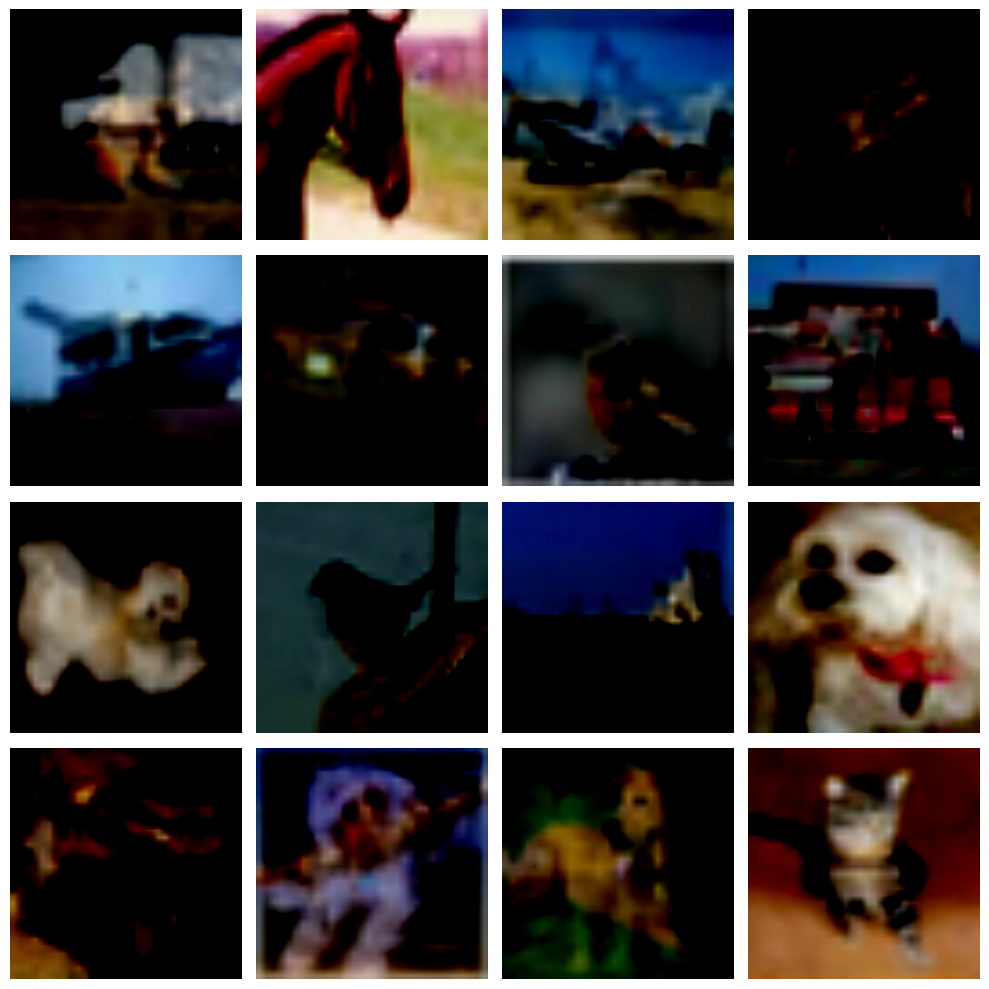

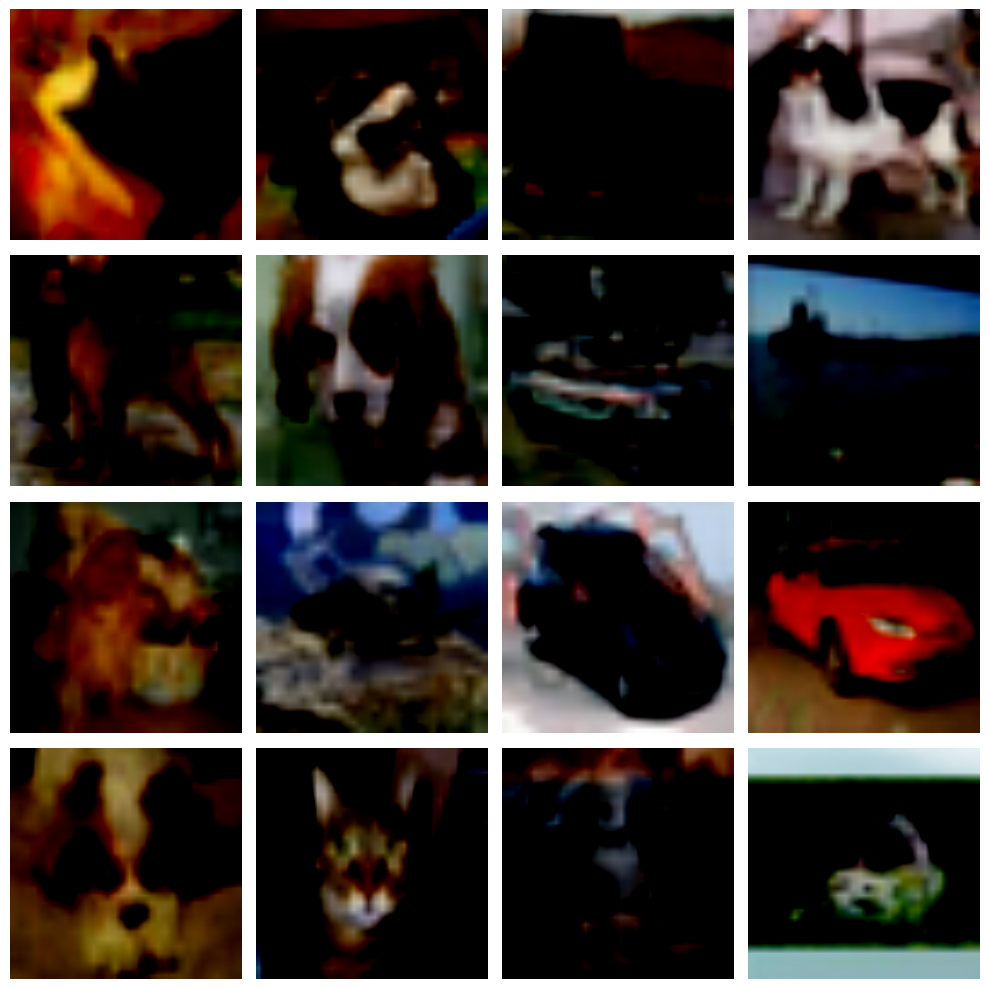

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dataset_mix = MixUp(train_dataset, alpha=0.4)
train_dataset_mix2 = MixUp(train_dataset, alpha=0.4, sampling_method=2)
train_dataset_mix.display_montage()
train_dataset_mix2.display_montage()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # 128
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
train_features, train_labels = next(iter(train_loader))

In [ ]:
train_labels[0]

tensor(2)

In [ ]:
device = "cuda"

In [ ]:
# Initialize the model
# Specify `weights=None` for random initialization or choose a pre-trained weight configuration
model = vit_b_16(pretrained=True)

# Adjust the classifier to CIFAR-10 (10 classes)
model.heads = nn.Sequential(
    nn.Linear(model.heads[0].in_features, 10)
)

model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def mixup(x, y, alpha=0.4, sampling_method=1):
    """
    Retrieve a mixed-up item from the dataset.
    """

    # Sample another index from the dataset
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    lam = sample_lambda(alpha=alpha, sampling_method=sampling_method)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def sample_lambda(alpha, sampling_method):
    """
    Sample the lambda value.
    """
    if sampling_method == 1:
        lambda_val = np.random.beta(alpha, alpha)
    elif sampling_method == 2:
        lambda_val = np.random.uniform(low=0.0, high=1.0)
    return lambda_val

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)




---



In [ ]:
# Training function
def train(model, trainloader, epochs=20):
    best_acc = 0.0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            #optimizer.zero_grad()

            images, labels_a, labels_b, lam = mixup(images, labels)
            #images, labels_a, labels_b = map(Variable, (images, labels_a, labels_b))

            with torch.autocast(device_type=device, dtype=torch.float16):
              outputs = model(images)
              loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}")

        test_acc = evaluate(model, test_loader)

        print(f"                 Test Acc: {test_acc}%")

        if test_acc>best_acc:
            torch.save(model.state_dict(), f"./2-1:ep{epoch}.pt")


# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

# Train the model
train(model, train_loader, epochs=20)

Epoch 1, Train Loss: 0.870100368509817
                 Test Acc: 96.51%
Epoch 2, Train Loss: 0.6217918277663343
                 Test Acc: 96.83%
Epoch 3, Train Loss: 0.6255354520952915
                 Test Acc: 97.21%
Epoch 4, Train Loss: 0.6083732828154893
                 Test Acc: 97.5%
Epoch 5, Train Loss: 0.5888136601661478
                 Test Acc: 97.68%
Epoch 6, Train Loss: 0.5584899037885849
                 Test Acc: 97.77%
Epoch 7, Train Loss: 0.5683245935746472
                 Test Acc: 97.7%


KeyboardInterrupt: 

In [ ]:
!cp /content/2-1:ep5.pt /content/drive/MyDrive



---



In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/2-1:ep5.pt"))
model.eval()

x, y = next(iter(test_loader))

x, y = x.to(device), y.to(device)

with torch.autocast(device_type='cuda', dtype=torch.float16):
    pred = model(x)

In [ ]:
def display_montage(x, pred, y):
    """
    Displays a montage of 16 mixed images from the dataset.
    """
    x, pred, y = x.cpu(), pred.cpu(), y.cpu()
    indices = np.random.choice(range(128), 36, replace=False)

    fig, axs = plt.subplots(6, 6, figsize=(10, 10))
    axs = axs.flatten()

    for ax, idx in zip(axs, indices):
        img = x[idx]
        # Tensor is in CxHxW format and needs to be converted to HxWxC for plotting
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.title.set_text("pred: "+str(classes[pred[idx].argmax().item()])+'\n'+"y: "+str(classes[y[idx].item()]))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

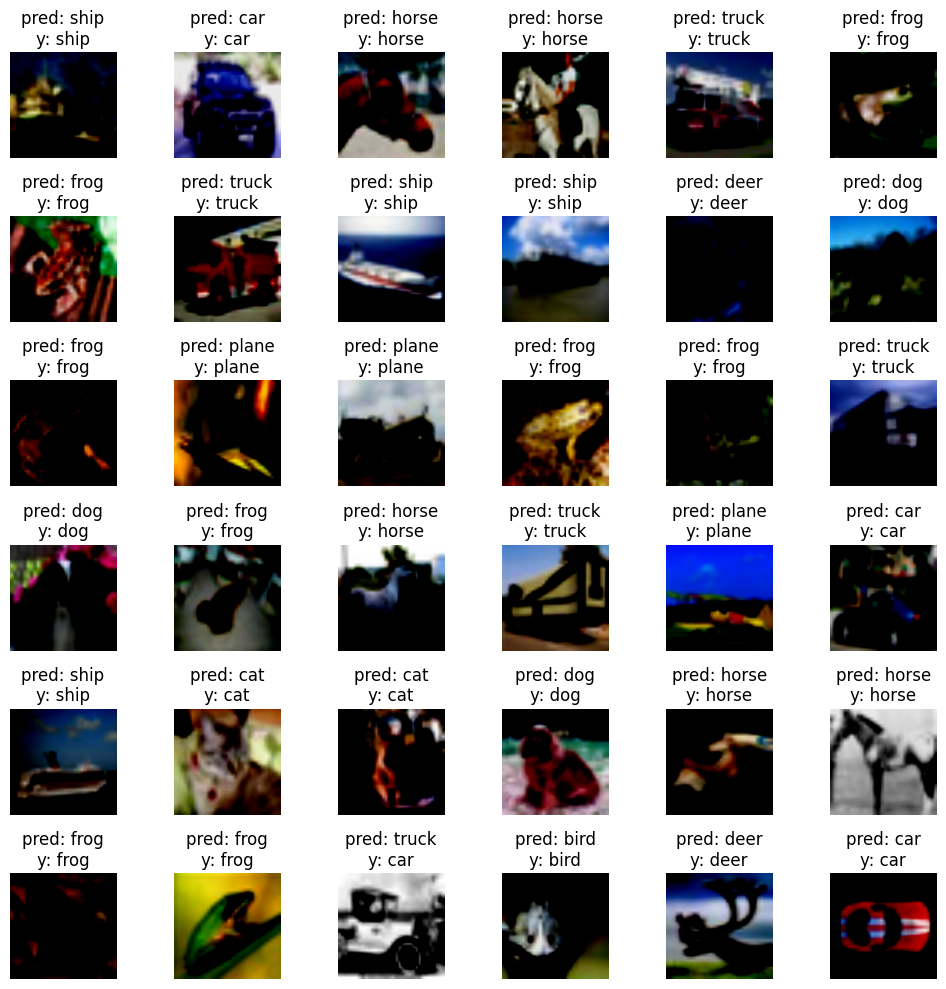

In [ ]:
display_montage(x, pred, y)

In [ ]:
# Training function
def train(model, trainloader, epochs=20):
    best_acc = 0.0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            #optimizer.zero_grad()

            images, labels_a, labels_b, lam = mixup(images, labels, sampling_method=2)
            #images, labels_a, labels_b = map(Variable, (images, labels_a, labels_b))

            with torch.autocast(device_type=device, dtype=torch.float16):
              outputs = model(images)
              loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}")

        test_acc = evaluate(model, test_loader)

        print(f"                 Test Acc: {test_acc}%")

        if test_acc>best_acc:
            torch.save(model.state_dict(), f"./2-1:ep{epoch}.pt")


# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

# Train the model
train(model, train_loader, epochs=20)

## T3

In [ ]:
def f1_score(y_true, y_pred, num_classes=10, epsilon=1e-7):
    """
    Calculate precision, recall, and F1 score for multi-class classification.

    Parameters:
    - y_true: Tensor of true class labels.
    - y_pred: Tensor of predicted class labels.
    - num_classes: Number of classes in the classification task.
    - epsilon: Small value to prevent division by zero.

    Returns:
    - precision: Tensor of precision scores for each class.
    - recall: Tensor of recall scores for each class.
    - f1: Tensor of F1 scores for each class.
    """

    # Convert to one-hot encoding
    one_hot = torch.eye(num_classes).to(device)
    y_true_one_hot = one_hot[y_true]
    y_pred_one_hot = one_hot[y_pred]

    # Calculate True Positives, False Positives, and False Negatives
    true_positives = torch.sum(y_true_one_hot * y_pred_one_hot, dim=0)
    predicted_positives = torch.sum(y_pred_one_hot, dim=0)
    actual_positives = torch.sum(y_true_one_hot, dim=0)

    # Calculate Precision, Recall
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (actual_positives + epsilon)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1.cpu()

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/2-1:ep5.pt"))

<All keys matched successfully>

In [ ]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct, F1, cnt = 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            cnt += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            F1 += f1_score(labels, predicted)

    test_acc = 100 * correct / total
    F1 /= cnt
    return test_acc, F1

In [ ]:
evaluate(model, test_loader)

(97.77,
 tensor([0.9859, 0.9842, 0.9829, 0.9482, 0.9576, 0.9547, 0.9814, 0.9823, 0.9896,
         0.9670]))

In [ ]:
cifar = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

In [ ]:
dev_set, hol_set = torch.utils.data.random_split(cifar, [48000, 12000])
train_set, val_set = torch.utils.data.random_split(cifar, [54000, 6000])

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(val_set, batch_size=128, shuffle=False)

In [ ]:
# Training function
def train(model, trainloader, epochs=20):
    best_acc = 0.0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            images, labels_a, labels_b, lam = mixup(images, labels, sampling_method=1)
            #images, labels_a, labels_b = map(Variable, (images, labels_a, labels_b))

            with torch.autocast(device_type=device, dtype=torch.float16):
              outputs = model(images)
              loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}")

        test_acc, F1 = evaluate(model, test_loader)

        print(f"                 Test Acc: {test_acc}%, F1: {F1}")

        if test_acc>best_acc:
            torch.save(model.state_dict(), f"./3-1-1:ep{epoch}.pt")


# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct, F1, cnt = 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            cnt += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            F1 += f1_score(labels, predicted)

    test_acc = 100 * correct / total
    F1 /= cnt
    return test_acc, F1

# Train the model
train(model, train_loader, epochs=1)

Epoch 1, Train Loss: 0.5752348723198989
                 Test Acc: 99.06666666666666%, F1: tensor([0.9934, 0.9951, 0.9939, 0.9794, 0.9890, 0.9794, 0.9943, 0.9910, 0.9950,
        0.9920])


In [ ]:
# Training function
def train(model, trainloader, epochs=20):
    best_acc = 0.0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            images, labels_a, labels_b, lam = mixup(images, labels, sampling_method=2)
            #images, labels_a, labels_b = map(Variable, (images, labels_a, labels_b))

            with torch.autocast(device_type=device, dtype=torch.float16):
              outputs = model(images)
              loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}")

        test_acc, F1 = evaluate(model, test_loader)

        print(f"                 Test Acc: {test_acc}%, F1: {F1}")

        if test_acc>best_acc:
            torch.save(model.state_dict(), f"./3-1-2:ep{epoch}.pt")


# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct, F1, cnt = 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            cnt += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            F1 += f1_score(labels, predicted)

    test_acc = 100 * correct / total
    F1 /= cnt
    return test_acc, F1

# Train the model
train(model, train_loader, epochs=1)

Epoch 1, Train Loss: 0.760557737801736
                 Test Acc: 99.0%, F1: tensor([0.9950, 0.9931, 0.9902, 0.9760, 0.9886, 0.9799, 0.9957, 0.9908, 0.9954,
        0.9898])


In [ ]:
train_loader = DataLoader(dev_set, batch_size=128, shuffle=True)
test_loader = DataLoader(hol_set, batch_size=128, shuffle=False)

In [ ]:
# Training function
def train(model, trainloader, epochs=20):
    best_acc = 0.0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            #optimizer.zero_grad()

            images, labels_a, labels_b, lam = mixup(images, labels, sampling_method=2)
            #images, labels_a, labels_b = map(Variable, (images, labels_a, labels_b))

            with torch.autocast(device_type=device, dtype=torch.float16):
              outputs = model(images)
              loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}")

        test_acc, f1 = evaluate(model, test_loader)

        print(f"                 Test Acc: {test_acc}%, F1: {f1}")

        if test_acc>best_acc:
            torch.save(model.state_dict(), f"./3-2-1:ep{epoch}.pt")


# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct, F1, cnt = 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            cnt += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            F1 += f1_score(labels, predicted)

    test_acc = 100 * correct / total
    F1 /= cnt
    return test_acc, F1

# Train the model
train(model, train_loader, epochs=1)

Epoch 1, Train Loss: 0.7676670360366503
                 Test Acc: 99.34166666666667%, F1: tensor([0.9963, 0.9961, 0.9926, 0.9847, 0.9916, 0.9878, 0.9960, 0.9940, 0.9976,
        0.9960])


In [ ]:
# Training function
def train(model, trainloader, epochs=20):
    best_acc = 0.0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            #optimizer.zero_grad()

            images, labels_a, labels_b, lam = mixup(images, labels, sampling_method=2)
            #images, labels_a, labels_b = map(Variable, (images, labels_a, labels_b))

            with torch.autocast(device_type=device, dtype=torch.float16):
              outputs = model(images)
              loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}")

        test_acc, f1 = evaluate(model, test_loader)

        print(f"                 Test Acc: {test_acc}%, F1: {f1}")

        if test_acc>best_acc:
            torch.save(model.state_dict(), f"./3-2-2:ep{epoch}.pt")


# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total, correct, F1, cnt = 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            cnt += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            F1 += f1_score(labels, predicted)

    test_acc = 100 * correct / total
    F1 /= cnt
    return test_acc, F1

# Train the model
train(model, train_loader, epochs=1)

Epoch 1, Train Loss: 0.7729278763234615
                 Test Acc: 99.3%, F1: tensor([0.9978, 0.9940, 0.9914, 0.9846, 0.9913, 0.9862, 0.9961, 0.9945, 0.9983,
        0.9942])


In [ ]:
!cp *.pt /content/drive/MyDrive